# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
np.random.seed(42)

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
# number of females and males

males = data[data['Sex'] == 'male']['Sex'].count()
females = data[data['Sex'] == 'female']['Sex'].count()

# number of survived and died passengers

survived = data[data['Survived'] == 1]['Survived'].count()
died = data[data['Survived'] == 0]['Survived'].count()

print(f"There're {males} males and {females} females. {survived} passengers survived, {died} passengers died.")
print('Summary statistic of gender and survival you can see in the table below.')
pd.crosstab(data['Sex'], data['Survived'], margins=True)

There're 577 males and 314 females. 342 passengers survived, 549 passengers died.
Summary statistic of gender and survival you can see in the table below.


Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


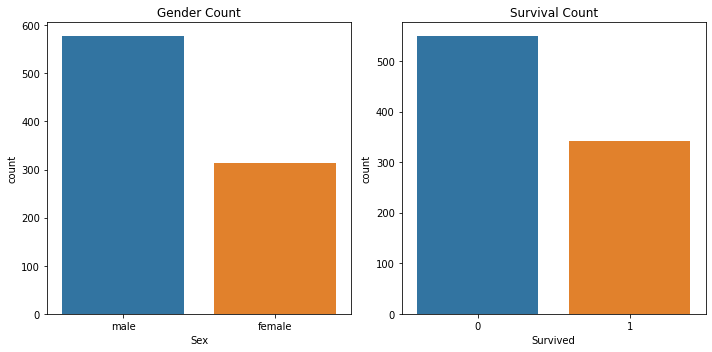

In [7]:
# visualising numbers

f, axs = plt.subplots(1, 3, figsize=(10,5))
plt.subplot(1, 2, 1)
sns.countplot(x='Sex',data=data).set_title('Gender Count')
plt.subplot(1, 2, 2)
sns.countplot(x='Survived', data=data).set_title('Survival Count')
plt.tight_layout()


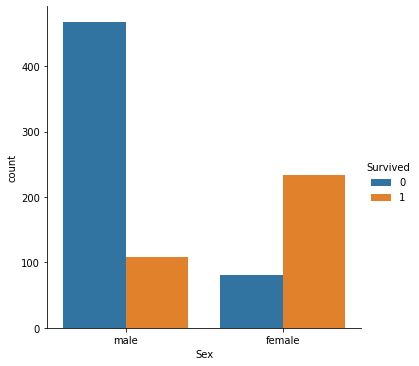

In [8]:
# relationship between gender and survival

data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()
sns.catplot(data = data, x ='Sex', hue ='Survived', kind ='count')

There's a strong relationship between gender and survival - women have much higher survival rates than men.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

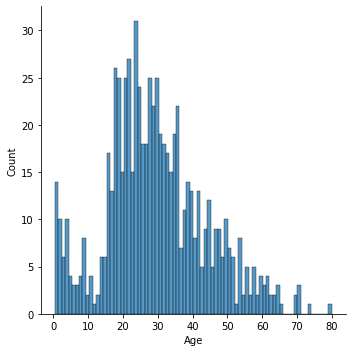

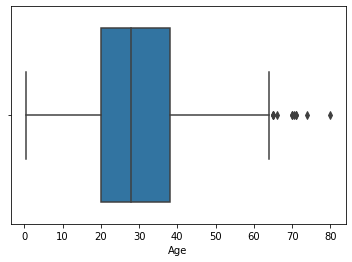

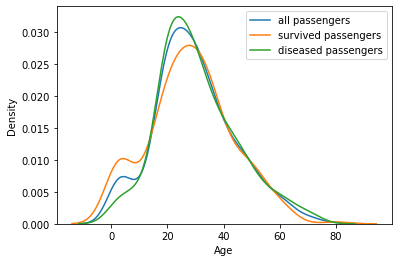

In [9]:
# age distribution of passengers
sns.displot(data['Age'], bins=80)
plt.show()
sns.boxplot(data=data, x='Age')
plt.show()
sns.kdeplot(data['Age'], label='all passengers')
sns.kdeplot(data[data['Survived'] == 1]['Age'], label='survived passengers')
sns.kdeplot(data[data['Survived'] == 0]['Age'], label='diseased passengers')
plt.legend()

In [10]:
# counting the mean and the median values

median_survived = data[data['Survived'] == 1]['Age'].median()
median_deceased = data[data['Survived'] == 0]['Age'].median()
average_survived = data[data['Survived'] == 1]['Age'].mean()
average_deceased = data[data['Survived'] == 0]['Age'].mean()
print(f'Average age for survived passengers - {average_survived:.2f}, median age - {median_survived}.')
print(f'Average age for deceased passengers - {average_deceased:.2f}, median age - {median_deceased}.')
data.groupby('Survived')['Age'].describe()

Average age for survived passengers - 28.34, median age - 28.0.
Average age for deceased passengers - 30.63, median age - 28.0.


,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


It doesn’t look like there was a huge difference in the age distribution of passengers who lived compared to those who died. Mean and median are almost the same - so we see a normal distribution. Some values on the left are missing - so it gets a bit skewed. I guess these distributions look the same because women and children were preferred to get on boats.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [11]:
# exploring numbers of survived and died passengers of different classes and embarkation ports

pd.crosstab([data['Pclass'], data['Embarked']], data['Survived'], margins=True)

Survived           0    1  All
Pclass Embarked               
1      C          26   59   85
       Q           1    1    2
       S          53   74  127
2      C           8    9   17
       Q           1    2    3
       S          88   76  164
3      C          41   25   66
       Q          45   27   72
       S         286   67  353
All              549  340  889

Text(0.5, 1.0, "'Safety' of Embarkation port")

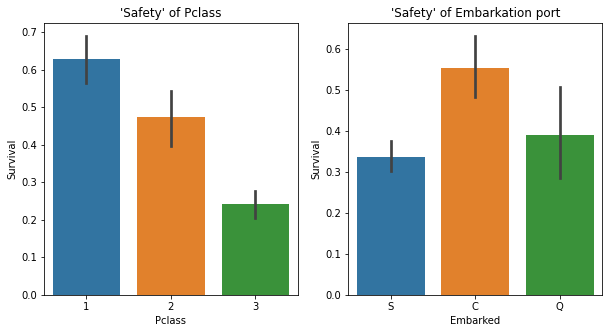

In [12]:
# visualizing class and port 'safety'

f, axs = plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1, 2, 1)
sns.barplot(x='Pclass', y='Survived', data=data)
plt.ylabel("Survival")
plt.title("'Safety' of Pclass")
plt.subplot(1, 2, 2)
sns.barplot(x='Embarked', y='Survived', data=data)
plt.ylabel("Survival")
plt.title("'Safety' of Embarkation port")


As we can see here - the safest class was 1st class(it has highest survival rate). Port of embarkment is not so significantly relevant to survival, but still we can say that C port passengers were more likely to survive. 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

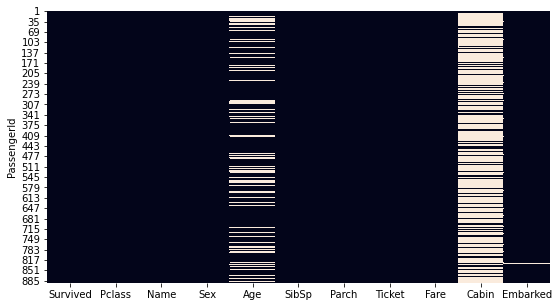

In [13]:
# visualizing NaN's

fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(data.isnull(), cbar=False)
plt.show()

In [14]:
# percentage of missing values for each feature

data.isnull().sum() * 100 / len(data)

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?


In [15]:
# make a copy of a dataset

new_data = data.copy()

1. Cabin feature has the most missing values - 77%, it's hard to deal with such a huge absence of information, but still we can unite them in a separate group and try to use.

In [16]:
# filling missing values with a separate group name

new_data['Cabin'] = data['Cabin'].fillna('Unknown')

In [17]:
# let's see what we have here

new_data['Cabin'].value_counts().sort_values(ascending=False).head(10)

Unknown        687
B96 B98          4
C23 C25 C27      4
G6               4
C22 C26          3
F2               3
D                3
E101             3
F33              3
C2               2
Name: Cabin, dtype: int64

In [18]:
# to use this feature as a categorical variable - let's strip numbers and leave only letters(may be a cabin type)

new_data['Cabin'] = new_data['Cabin'].apply(lambda x: x[0])

# looks much better

new_data['Cabin'].value_counts().sort_values(ascending=False)

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

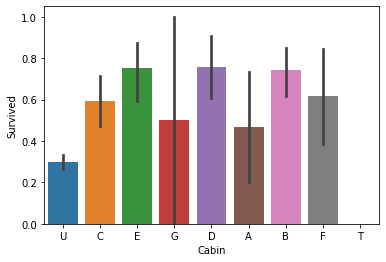

In [19]:
# cabin - survival dependency

sns.barplot(x='Cabin', y='Survived', data=new_data)

Some cabins had higher rates of survival but it might not really influence the model. 

2. Age feature can be filled with mean/median value or we can handle it more carefully. We can replace missing values by extracting a title from passengers' names and finding an average age for each title. This would make missing ages less artificial. I wouldn't use Age feature in my final model though - so I'm just gonna close this issue with median.

In [20]:
# imputing na values with median

new_data['Age'] = data['Age'].fillna(data['Age'].median())

#check if there's any left

new_data['Age'].isna().sum()

0

3. Also we have 2 missing values in Embarked category.

In [21]:
data[data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


As they are 1st class passengers we can fill these values with the most frequent post for 1st class - S.

In [22]:
new_data['Embarked'] = data['Embarked'].fillna('S')

In [23]:
# no missing values in the training data anymore - yay!

new_data.isna().sum().sum()

0

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [24]:
y = data['Survived']

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

#### Preparing features

In [25]:
# Name field can be used for title extraction(title combines age and gender information)

new_data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
new_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Sir               1
Jonkheer          1
Don               1
Mme               1
Ms                1
Capt              1
the Countess      1
Lady              1
Name: Title, dtype: int64

In [26]:
# there're some rare ones - we can replace them with 'other'

new_data['Title'] = new_data.apply(lambda row: 'Other' if row['Title'] not in ('Mr', 'Miss', 'Mrs', 'Master') else row['Title'], axis=1)

In [27]:
# SibSp and Parch might be useful to unite

new_data['Family'] = data['SibSp'] + data['Parch']

Fare distribution needs to be visualized as it is highly skewed. 

<AxesSubplot:xlabel='Fare', ylabel='Count'>

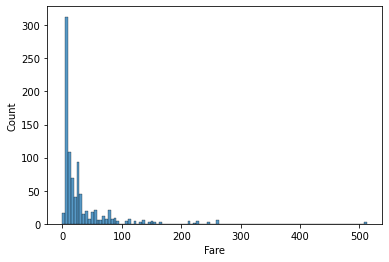

In [28]:
sns.histplot(data=data, x="Fare")

I tried to use log normalization method, mentioned in previous lecture - and it helped with score.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

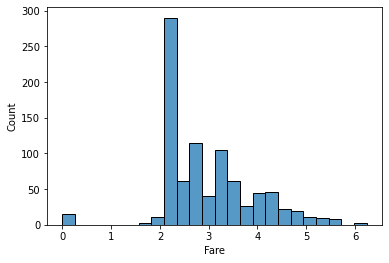

In [29]:
# some fare values are close to zero so I use np.log(x+1)

new_data['Fare'] = data['Fare'].apply(lambda x: np.log(x + 1)).astype(np.float64)
sns.histplot(data=new_data, x="Fare")

We don't need a Name, SibSp and Parch column anymore.  
I tried to use Ticket column by extracting the number - but it didn't give much effect on model perfomance unfortunately.

In [30]:
# binarization of categorical variables

new_data = pd.get_dummies(new_data, columns=['Title', 'Sex', 'Pclass'])

Text(0.5, 1.0, 'Feature correlation matrix')

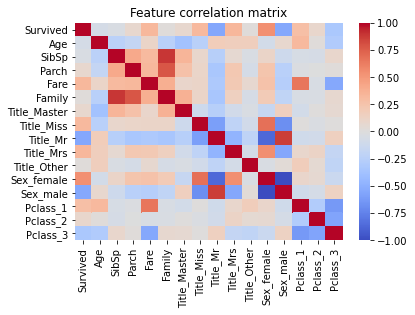

In [31]:
# feature correlation heatmap

sns.heatmap(new_data.corr(),cmap='coolwarm')
plt.title('Feature correlation matrix')

We don't need a Name, SibSp and Parch column anymore.
I tried to use Ticket column by extracting the number - but it didn't give much effect on model perfomance unfortunately.

In [32]:
# dropping unnecessary columns

train_data = new_data.drop(['Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1)

# checking correlation with target

train_data.corr().abs().unstack()['Survived'].drop_duplicates().sort_values(ascending=False).head(10)

Survived        1.000000
Title_Mr        0.549199
Sex_female      0.543351
Title_Mrs       0.339040
Fare            0.329862
Title_Miss      0.327093
Pclass_3        0.322308
Pclass_1        0.285904
Pclass_2        0.093349
Title_Master    0.085221
dtype: float64

In [33]:
X_train = train_data.iloc[:,1:]
y_train = data['Survived']
X_train

,Fare,Family,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,
1,2.110213,1,0,0,1,0,0,0,1,0,0,1
2,4.280593,1,0,0,0,1,0,1,0,1,0,0
3,2.188856,0,0,1,0,0,0,1,0,0,0,1
4,3.990834,1,0,0,0,1,0,1,0,1,0,0
5,2.202765,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
887,2.639057,0,0,0,0,0,1,0,1,0,1,0
888,3.433987,0,0,1,0,0,0,1,0,1,0,0
889,3.196630,3,0,1,0,0,0,1,0,0,0,1


In [34]:
# scaling training data

X_train = StandardScaler().fit_transform(X_train)

In [35]:
# modelling

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
# cross validation knn accuracy score on training set

cross_val_score(knn, X_train, y_train).mean()

0.8159688657334756

In [37]:
# cross validation logistic regression accuracy score on training set

cross_val_score(logreg, X_train, y_train).mean()

0.8260372857949909

Text(0, 0.5, 'accuracy cv')

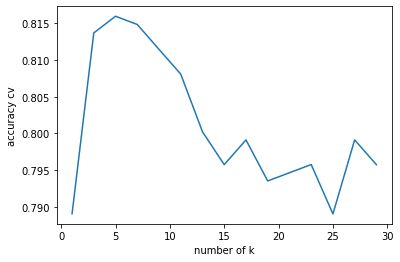

In [38]:
# let's try some hyper parameter tuning for both models and check performance

# looping for odd values of k to 30

k_range = range(1, 31, 2)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# visualizing dependency: accuracy - k number
plt.plot(k_range, k_scores)
plt.xlabel('number of k')
plt.ylabel('accuracy cv')

In [39]:
# we can assume that 5 is the perfect k number
# other parameters were found during experiments with GridSearchCV and were manually corrected after

knn = KNeighborsClassifier(n_neighbors=5, p=1, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(p=1)

In [40]:
# new cross validation knn accuracy score on training set

cross_val_score(knn, X_train, y_train).mean()

0.819327098110602

In [41]:
# these parameters were found during experiments with GridSearchCV and were manually corrected after

logreg = LogisticRegression(solver='liblinear', C=0.04, penalty='l2', random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.04, random_state=42, solver='liblinear')

In [42]:
# new cross validation logistic regression accuracy score on training set

cross_val_score(logreg, X_train, y_train).mean()

0.8226539451384094

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [43]:
# loading test set

test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [44]:
# defifning a function for feature preparation on test set

def feat_prep(data):
    data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    data['Title'] = data.apply(lambda row: 'Other' if row['Title'] not in ('Mr', 'Miss', 'Mrs', 'Master') else row['Title'], axis=1)
    data['Family'] = data['SibSp'] + data['Parch']
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Fare'] = data['Fare'].apply(lambda x: np.log(x + 1).astype(np.float64))
    data = pd.get_dummies(data, columns=['Title', 'Sex', 'Pclass'])
    data = data.drop(['Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    return data

In [45]:
# test feature preparation and checking if threre any missing values left

new_test = feat_prep(test)
new_test.isna().sum().sum()

0

In [46]:
# scaling test features

X_test = StandardScaler().fit_transform(new_test.iloc[:,1:])

In [47]:
# making predictions

y_pred_knn = knn.predict(X_test) 
y_pred_logreg = logreg.predict(X_test)


Screenshot from kaggle submission page

<img src="data/titanic/screen_score.png"/>

Knn performed better - the highest score I received on kaggle is <b> 0.78229 </b>  
Final model - KNeighborsClassifier(n_neighbors=5, p=1, weights='uniform')  
features - Fare, Family(SibSp, ParCh), Title(from Name), Sex, Pclass.  
account link -  https://www.kaggle.com/polinaroschina  

In [48]:
#test['Survived'] = knn.predict(X_test)                            # <- uncomment this cell if you want
#submission = test[['PassengerId', 'Survived']]                    # <- to form a submission file
#submission.to_csv('data/titanic/submission_knn.csv', index=False) # <- and check the output score on kaggle

#submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
